# LVAC: Learned Volumetric Attribute Compression for Point Clouds using Coordinate Based Networks
Berivan Isik, Philip A. Chou, Sung Jin Hwang, Nick Johnston, George Toderici   

<br>
We consider the attributes of a point cloud as samples of a vector-valued volumetric function at discrete positions. To compress the attributes given the positions, we compress the parameters of the volumetric function. We model the volumetric function by tiling space into blocks, and representing the function over each block by shifts of a coordinate-based, or implicit, neural network. Inputs to the network include both spatial coordinates and a latent vector per block. We represent the latent vectors using coefficients of the region-adaptive hierarchical transform (RAHT) used in the MPEG geometry-based point cloud codec G-PCC. The coefficients, which are highly compressible, are rate-distortion optimized by back-propagation through a rate-distortion Lagrangian loss in an auto-decoder configuration. The result outperforms the transform in the current standard, RAHT, by 2-4 dB and a recent non-volumetric method, Deep-PCAC, by 2-5 dB at the same bit rate. This is the first work to compress volumetric functions represented by local coordinate-based neural networks. As such, we expect it to be applicable beyond point clouds, for example to compression of high-resolution neural radiance fields.</br>
<br></br>

  
Please cite our work using:
```
@article{10.3389/frsip.2022.1008812,
  doi = {10.3389/frsip.2022.1008812},
  url = {https://www.frontiersin.org/articles/10.3389/frsip.2022.1008812/},
  author = {Isik, Berivan and Chou, Philip A. and Hwang, Sung Jin and Johnston, Nick and Toderici, George},
  title={LVAC: Learned Volumetric Attribute Compression for Point Clouds using Coordinate Based Networks},
  journal={Frontiers in Signal Processing},
  year={2022}
}
```


# Dependencies and Setup for Training/Evaluation LVAC model

In [ ]:
#@title Install TensorFlow 2 and other dependencies.
# Import TensorFlow and install additional Python packages.
%tensorflow_version 2.x

# Required for training and processing input data
%pip install ml_collections
%pip install plyfile
%pip install pyglib
%pip install tensorflow-compression~=$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+\.\d+).*/\1.0/sg')
%pip install tqdm

In [ ]:
#@title Mount Google Drive.
#@markdown We use Google Drive to store checkpoints and load training/evaluation
#@markdown PLY files. You will be prompted to give Colab permission for access.
#@markdown If you don't want or cannot give this access. You will have to
#@markdown provide alternate methods to load your data.
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# Utility functions

We provide a number of utility functions to help us process our input data and implement the RLGR encoding.

In [ ]:
#@title PLY Utilties
import functools
import numpy as np
import tensorflow as tf
import plyfile
import os

assert tf.executing_eagerly()


def _extract_from_plystruct(plystruct):
  """Extract fields from ply struct into dictionary.

  Args:
    ply_struct: PlyData struct (e.g., obtained by PlyData.read('filename.ply'))

  Returns:
    A tuple of two arrays (position, attribute=color).
  """
  vertex_position = None
  vertex_color = None

  for elt in plystruct.elements:
    data = elt.data
    names = data.dtype.names

    if elt.name == "vertex":
      if ("x" in names) and ("y" in names) and ("z" in names):
        assert vertex_position is None
        vertex_position = np.c_[data["x"], data["y"], data["z"]]

      if ("red" in names) and ("blue" in names) and ("green" in names):
        assert vertex_color is None
        vertex_color = np.c_[data["red"], data["green"], data["blue"]]

  return vertex_position, vertex_color

def _replace_color_in_plystruct(plystruct, colors):
  """Replaces colors in a ply struct.

  Args:
    ply_struct: PlyData struct (e.g., obtained by PlyData.read('filename.ply'))
    colors: A Numpy array of shape (number of vertices, 3).

  Returns:
    Color modified PlyData struct.
  """ 
  for elt_index, elt in enumerate(plystruct.elements):
    data = elt.data
    names = data.dtype.names

    if elt.name == "vertex":
      if ("red" in names) and ("blue" in names) and ("green" in names):
        r, g, b = np.split(colors, 3, axis=1)
        plystruct.elements[elt_index].data["red"] = np.squeeze(r)
        plystruct.elements[elt_index].data["green"] = np.squeeze(g)
        plystruct.elements[elt_index].data["blue"] = np.squeeze(b)
        break
  return plystruct

@functools.lru_cache(maxsize=None)
def read_plyfile(filename):
  with tf.io.gfile.GFile(filename, "rb") as f:
    plystruct = plyfile.PlyData.read(f)
  return _extract_from_plystruct(plystruct)

def create_new_plyfile(old_filename, new_filename, colors):
  with tf.io.gfile.GFile(old_filename, "rb") as f:
    plystruct = plyfile.PlyData.read(f)
  new_plystruct = _replace_color_in_plystruct(plystruct, colors)
  with tf.io.gfile.GFile(new_filename, "wb") as g:
    new_plystruct.write(g)
  return
  


In [ ]:
#@title RLGR
"""This module supplies functions for run-length golomb-rice (rlgr) coding.

rlgr: encoding function
irlgr: decoding function

Example usage:

  from numpy import random
  R = random.randint(-10, 11, 100000).astype(np.int32)
  bitStreamCount, bitStream = rlgr(R, return_bitstream=True)
  N = len(R)
  R_hat = irlgr(bitStream, N)
  assert np.all(R == R_hat)
"""
import io
import numpy as np


class BitWriter:

  def __init__(self):
    self.sink = io.BytesIO()
    self.buffer = 0
    self.offset = 0
  
  def write(self, val: int, n: int) -> None:
    """Writes lower `n` bits of `val`."""
    assert 0 <= self.offset <= 32, self.offset
    assert 0 <= n <= 32, n

    room = 32 - self.offset
    if n <= room:
      val &= (1 << n) - 1
      self.buffer |= (val << self.offset)
      self.offset += n
      return

    self.write(val, room)
    val >>= room
    n -= room

    assert self.offset == 32, self.offset
    self.sink.write(int(self.buffer).to_bytes(4, "little", signed=False))  # 4 bytes.
    self.buffer = 0
    self.offset = 0

    assert 0 < n <= 32, n
    self.write(val, n)
    
  def write_run_length(self, n: int) -> None:
    assert 0 <= n <= 31
    self.write(1 << n, n + 1)

  def finalize(self) -> bytes:
    self.write(1, 1)  # End-of-sequence marker.
    n = (self.offset + 7) // 8
    self.sink.write(int(self.buffer).to_bytes(n, "little", signed=False))
    output = self.sink.getvalue()
    self.sink.close()
    return output


class BitReader:

  def __init__(self, source: bytes):
    self.source = io.BytesIO(source)
    self.buffer = 0
    self.remain = 0

  def _read_from_source(self) -> None:
    read = self.source.read(4)
    assert read, "Read past the end of the source."
    assert len(read) <= 4, read

    self.buffer = int.from_bytes(read, "little", signed=False)
    self.remain = len(read) * 8

  def read(self, n: int) -> int:
    assert 0 <= n <= 32, n
    assert 0 <= self.remain <= 32, self.remain
    if n <= self.remain:
      val = self.buffer & ((1 << n) - 1)
      self.buffer >>= n
      self.remain -= n
      return val
    
    val = self.buffer
    offset = self.remain
    n -= self.remain

    self._read_from_source()
    val |= self.read(n) << offset
    return val

  def read_run_length(self) -> int:
    # Maximum is 32.
    if self.buffer != 0:
      n = (self.buffer ^ (self.buffer - 1)).bit_length()
      assert n != 0, n
      assert n <= self.remain, (self.buffer, self.remain)
      self.buffer >>= n
      self.remain -= n
      return n - 1

    n = self.remain
    self._read_from_source()
    return n + self.read_run_length()


def rlgr(x: np.ndarray) -> bytes:
  """Encodes with Adaptive Run Length Golomb Rice coding.

  Args:
    x: An array of signed integers to be coded.

  Returns:
    A Python `bytes`.
  """
  assert x.dtype == np.int32, x.dtype
  x = np.ravel(x)
  assert np.all(x <= ((1 << 30) - 1))
  assert np.all(-(1 << 30) <= x)

  sink = BitWriter()

  # Constants.
  L = 4
  U0 = 3
  D0 = 1
  U1 = 2
  D1 = 1
  quotientMax = 24

  # Initialize state.
  k_P = 0
  k_RP = 10 * L

  # Preprocess data from signed to unsigned.
  z = x * 2
  z[z < 0] += 1
  z = np.abs(z)

  N = len(z)
  n = 0
  while n < N:
    k = k_P // L
    k_RP = min(k_RP, 31 * L)
    k_R = k_RP // L

    u = z[n]  # Symbol to encode.

    if k != 0:  # Encode zero runs.
      m = 1 << k  # m = 2**k = expected length of run of zeros

      # Count the run length of zeros, up to m.
      ahead = z[n:n + m]
      zero_count = np.argmax(ahead != 0)  # np.argmax returns the _first_ index.
      if ahead[zero_count] == 0:  # In case (ahead == 0).all() is true.
        zero_count = len(ahead)

      n += zero_count
      if zero_count == len(ahead):
        # Found a complete run of zeros.
        # Write a 0 to denote the run was a complete one.
        sink.write(0, 1)

        # Adapt k.
        k_P += U1
        continue

      # Found a partial run of zeros (length < m).
      # Write a 1 to denote the run was a partial one, and the decoder needs
      # to read k bits to extract the actual run length.
      sink.write(1, 1)
      sink.write(zero_count, k)

      # The next symbol is encoded as z[n] - 1 instead of z[n].
      assert z[n] != 0
      u = z[n] - 1

    # Output GR code for symbol u.
    # bits = bits + gr(u,k_R)
    assert 0 <= u, u
    quotient = u >> k_R  # `quotient` is run-length encoded.
    if quotient < quotientMax:
      sink.write_run_length(quotient)
      sink.write(u, k_R)
    else:
      assert int(u).bit_length() <= 31, (u, u.bit_length())
      sink.write_run_length(quotientMax)
      sink.write(u, 31)

    # Adapt k_R.
    if quotient == 0:
      k_RP = max(0, k_RP - 2)
    elif quotient > 1:
      k_RP += quotient + 1

    # Adapt k.
    if k == 0 and u == 0:
      k_P += U0
    else:  # k > 0 or u > 0
      k_P = max(0, k_P - D0)

    n += 1

  output = sink.finalize()
  return output


def irlgr(source: bytes, N: int) -> np.ndarray:
  """IRLGR decodes bitStream into integers using Adaptive Run Length Golomb Rice.

  Args:
    source: A Python `bytes`.
    N: Number of symbols to decode.

  Returns:
    An array of decoded signed integers.
  """
  # Constants.
  L = 4
  U0 = 3
  D0 = 1
  U1 = 2
  D1 = 1
  quotientMax = 24

  source = BitReader(source)

  # Initialize state.
  k_P = 0
  k_RP = 10 * L

  # Allocate space for decoded unsigned integers.
  output = np.zeros(N, np.int32)

  # Process data one sample at a time (time consuming in Matlab).
  n = 0
  while n < N:
    k = k_P // L
    k_RP = min([k_RP, 31 * L])
    k_R = k_RP // L

    if k != 0:
      is_complete = (source.read(1) == 0)
      if is_complete:
        zero_count = 1 << k  # 2**k = expected length of run of zeros
        output[n:n + zero_count] = 0
        n += zero_count

        # Adapt k.
        k_P += U1
        continue

      # A partial run was encoded.
      zero_count = source.read(k)
      output[n:n + zero_count] = 0
      n += zero_count

    quotient = source.read_run_length()
    if quotient < quotientMax:
      u = (quotient << k_R) + source.read(k_R)
    else:
      u = source.read(31)
      quotient = u >> k_R

    # Adapt k_R.
    if quotient == 0:
      k_RP = max(0, k_RP - 2)
    elif quotient > 1:
      k_RP += quotient + 1

    # Adapt k.
    if k == 0 and u == 0:
      k_P += U0
    else:  # k > 0 or u > 0
      k_P = max(0, k_P - D0)

    output[n] = u if k == 0 else u + 1
    n += 1

  # Postprocess data from unsigned to signed.
  is_negative = (output % 2 == 1)
  output = ((output + 1) // 2) * np.where(is_negative, -1, 1)
  return output


def rlgr_test(n):
  rng = np.random.default_rng()
  x = rng.laplace(scale=1e+5, size=n)
  x = np.round(x).astype(np.int32)

  xhat = irlgr(rlgr(x), n)
  np.testing.assert_array_equal(x, xhat)

rlgr_test(4096)

In [ ]:
#@title Voxelized Point Clouds
import numpy as np


def morton_from_position(position: np.ndarray) -> np.ndarray:
  """Convert integer (x,y,z) positions to Morton codes.

  Args:
    positions: Nx3 int32 numpy array

  Returns:
    An int64 numpy array of shape [N].
  """
  position = np.asarray(position, dtype=np.int64)
  morton_code = np.zeros(len(position), dtype=np.int64)
  coeff = np.asarray([4, 2, 1], dtype=np.int64) 
  for b in range(21):
    morton_code |= ((position & (1 << b)) << (2 * b)) @ coeff
  return morton_code


In [ ]:
#@title Octree Utilities
from typing import Sequence, Tuple

import numpy as np
import tensorflow as tf


def build_octree_as_binarytree(
    position: np.ndarray,
    target_level: int) -> Tuple[Sequence[tf.Module], int]:
  """Constructs binary tree representation of the octree."""
  assert len(position) <= np.iinfo(np.int32).max
  morton_code = morton_from_position(position)

  # Assert that morton codes are unique and in sorted order.
  assert np.all(np.unique(morton_code) == morton_code)
  assert np.all(np.sort(morton_code) == morton_code)

  max_morton = morton_code[-1]
  depth = (int(max_morton).bit_length() + 2) // 3
  print("Octree depth is:", depth)
  assert depth != 0
  
  binlevel = [tf.Module() for i in range(target_level + 1)]

  # Amount of shift at the target level.
  base_shift = 3 * depth - target_level
  assert 0 <= base_shift
  morton_code >>= base_shift

  for shift in range(target_level + 1):
    level = binlevel[-(shift + 1)]

    level.prefix, level.descendant_count = np.unique(morton_code, return_counts=True)
    morton_code >>= 1

    assert np.issubdtype(position.dtype, np.floating), position.dtype
    block_size = 1 << ((shift + base_shift + np.arange(3)) // 3)
    level.relative_position = np.fmod(position, block_size)

    if shift == 0:
      continue

    child_level = binlevel[-shift]
    # .parent is not used anywhere at this moment.
    _, first_child, child_level.parent, level.child_count = np.unique(
        child_level.prefix >> 1,
        return_index=True, return_inverse=True, return_counts=True)

    first_child_of_two = first_child[level.child_count == 2]
    nl = child_level.descendant_count[first_child_of_two + 0]
    nr = child_level.descendant_count[first_child_of_two + 1]

    level.latent_scale = np.sqrt(nr * (nl + nr) / nl)
    assert np.isfinite(level.latent_scale).all()

    level.latent_segment_id = np.ravel(
        np.stack((first_child_of_two, first_child_of_two + 1), axis=-1))

    level.latent_coeff = (-nr / nl).astype(np.float32)
    level.latent_coeff = np.expand_dims(level.latent_coeff, -1)

  np.testing.assert_array_equal(binlevel[0].relative_position, position)
  return binlevel, depth


In [ ]:
#@title Color Space and RLGR inference
from typing import Sequence

import tensorflow as tf


def convert_rgb_to_yuv(rgb):
  """Convert RGB in range [0,255] to YUV in range [0,255]."""
  r, g, b = tf.split(rgb, 3, axis=-1)
  y = 0.212600 * r + 0.715200 * g + 0.072200 * b
  u = -0.114572 * r - 0.385428 * g + 0.5 * b + 128.0
  v = 0.5 * r - 0.454153 * g - 0.045847 * b + 128.0
  yuv = tf.concat((y, u, v), axis=-1)
  return yuv


def convert_yuv_to_rgb(yuv):
  """Convert YUV in range [0,255] to RGB in range [0,255]."""
  y, u, v = tf.split(yuv, 3, axis=-1)
  u128 = u - 128.0
  v128 = v - 128.0
  r = y + 1.57480 * v128
  g = y - 0.18733 * u128 - 0.46813 * v128
  b = y + 1.85563 * u128
  rgb = tf.concat((r, g, b), axis=-1)
  return rgb


def run_rlgr(coeffs: Sequence[tf.Tensor]) -> int:
  """Run-length Golomb_Rice coding to be used at inference."""
  coeffs = tf.concat(coeffs, axis=0).numpy()
  # assert coeffs.shape[1] == config.num_channels
  nbytes = sum(len(rlgr(coeffs[:, i])) for i in range(coeffs.shape[1]))
  return nbytes * 8


In [ ]:
class PositionAttentionLayer(tf.keras.layers.Layer):
  """ Position Attention Layer.
       positional_channels: number of position coordinates (3 for x, y, z)
       latent_channels: number of channels in the latents
       output_channels: number of channels in the output (3 for RGB)
     returns estimated RGB colors
  """

  def __init__(self,
               positional_channels=3,
               latent_channels=32,
               output_channels=3):
    super().__init__()
    self.positional_channels = positional_channels
    self.latent_channels = latent_channels
    self.output_channels = output_channels

  def build(self, input_shape):
    del input_shape  # Unused.

    initializer = tf.random_normal_initializer()
    self.dense0 = tf.keras.layers.Dense(self.latent_channels,
                                        use_bias=True,
                                        kernel_initializer=initializer)
    self.dense1 = tf.keras.layers.Dense(self.output_channels,
                                        use_bias=True,
                                        kernel_initializer=initializer)

  def call(self, inputs):
    position = inputs[:, :self.positional_channels]
    latent = inputs[:, self.positional_channels:]
    position_encoding = tf.math.sin(self.dense0(position))
    return self.dense1(latent * position_encoding)


# Double Check Runtime Device
For example soldier_vox10_0690.ply takes around 2.5 hours to fully train
on the default configuration on a NVIDIA T4 GPU through Google Cloud.

## Caution when using GPU
When the ply file contains too many vertices, the training process may experience OOM errors, or may create temporaries too large for int32 to index. The encountered error message may not be intuitive, e.g.,
```
Check failed: work_element_count > 0 (-361458720 vs. 0) 
```
in `gpu_launch_config.h`. In these cases, please consider using CPU or splitting the ply files into smaller ones.


In [ ]:
!nvidia-smi

# LVAC Model Code
This code is creates the model, training and evaluation setup needed. 

In [ ]:
"""Code for Learned Volumetric Attribute Compression (LVAC)."""

import datetime
from typing import Sequence

from absl import logging

import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc

from tqdm import tqdm



class Model(tf.Module):

  def __init__(self, config):
    super().__init__()
    self.config = config
    if self.config.extractor_model == "linear":
      self.config.num_channels = 3
      self.config.position_type = "none"

    self.latent_variables = []

    # Read the point cloud.
    print(f"Reading {self.config.original_vpc}...")
    position, colors = read_plyfile(self.config.original_vpc)
    # Keep a copy of each around.
    self.original_position = position
    self.original_colors = colors
    assert len(colors) == len(position)
    self.count = len(position)

    self.colors = tf.convert_to_tensor(colors.astype(np.float32))
    # If PSNR is in YUV space, convert attributes from RGB to YUV.
    if self.config.distortion_colorspace.lower() == "yuv":
      self.colors = tf.clip_by_value(
          convert_rgb_to_yuv(self.colors), 0.0, 255.0)

    self.binlevel, self.depth = build_octree_as_binarytree(
        position, self.config.target_level)

    def make_latent_variable(n):
      initializer = tf.random_normal_initializer()
      variable = tf.Variable(initializer(shape=[n, self.config.num_channels],
                                        dtype=tf.float32), trainable=True)
      self.latent_variables.append(variable)
      return variable

    def make_entropy_model(name):
      prior = tfc.NoisyDeepFactorized(
          batch_shape=[self.config.num_channels], name=name)
      return tfc.ContinuousBatchedEntropyModel(
          prior=prior, coding_rank=1, compression=False)

    # Initialize latent variables and entropy models.
    root = self.binlevel[0]
    assert len(root.prefix) == 1, root.prefix
    root.latent_dc = make_latent_variable(len(root.prefix))
    root.entropy_model_dc = make_entropy_model(f"entropy_model_dc")

    for b in range(self.config.target_level):
      level = self.binlevel[b]
      assert np.count_nonzero(level.child_count == 2) == len(level.latent_scale)
      level.latent_ac = make_latent_variable(len(level.latent_scale))
      level.entropy_model_ac = make_entropy_model(f"entropy_model_ac_{b}")

      if not self.config.normalization:
        level.latent_scale = np.ones_like(level.latent_scale)

    # Global latent step scale used in entropy coding.
    self.delta_high = tf.Variable(
        tf.ones([1, self.config.num_channels], dtype=tf.float32))
        
    # Initialize MLP.
    if self.config.extractor_model == "mlp":
      self.mlp = tf.keras.models.Sequential([
          tf.keras.layers.Dense(self.config.hidden_dim, activation=tf.nn.relu),
          tf.keras.layers.Dense(3, activation=None),
      ])
    elif self.config.extractor_model == "linear":
      self.mlp = tf.keras.layers.Dense(3, activation=None, use_bias=False)
    elif self.config.extractor_model == "pa":
      self.mlp = PositionAttentionLayer(
          positional_channels=3,
          latent_channels=self.config.num_channels,
          output_channels=3)
    else:
      raise ValueError("Extractor model not implemented: " +
                       self.config.extractor_model)

    # Initialize optimizers.
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.config.lr)
    if self.config.latent_optimizer == "Adam":
      self.latent_optimizer = tf.keras.optimizers.Adam(
          learning_rate=self.config.lr)
    else:
      self.latent_optimizer = tf.keras.optimizers.SGD(
          learning_rate=self.config.lr)

  @tf.function
  def entropy_coding(self, training: bool):
    """Entropy coding of latents for training."""
    delta_high = tf.math.softplus(self.delta_high)

    def fake_quantize_and_loss(entropy_model, latent, scale):
      inv_step_size = np.expand_dims(scale, -1) / delta_high
      if training:
        coeff, estimated_nbits = entropy_model(latent * inv_step_size,
                                              training=training)
        quantized = None
      else:
        tf.debugging.assert_rank(latent, 2)
        if latent.shape[0] < 10:
          # The cost of distribution modeling is higher than simple
          # quantization. In this case, we quantize to bfloat16 instead.
          # Consider removing tf.round below.
          coeff = tf.cast(tf.round(latent * inv_step_size), tf.bfloat16)
          coeff = tf.cast(coeff, tf.float32)  # Cast back as dequantize.
          quantized = tf.cast(coeff, tf.int32)
          estimated_nbits = 16.0 * tf.ones_like(latent) 
        else:        
          coeff, estimated_nbits = entropy_model(latent * inv_step_size,
                                                training=training)
          quantized = coeff - entropy_model.quantization_offset
          quantized = tf.cast(tf.round(quantized), tf.int32) 
      entropy_loss = tf.math.reduce_sum(estimated_nbits)
      return coeff / inv_step_size, quantized, entropy_loss

    output = [fake_quantize_and_loss(
        self.binlevel[0].entropy_model_dc,
        self.binlevel[0].latent_dc,
        np.sqrt(self.count),
    )]
    output.extend(fake_quantize_and_loss(
        self.binlevel[b].entropy_model_ac,
        self.binlevel[b].latent_ac,
        self.binlevel[b].latent_scale
    ) for b in range(self.config.target_level))

    latent, quantized, entropy_loss = zip(*output)
    for tensor in latent:
      tensor.shape.assert_is_fully_defined()

    entropy_loss = tf.math.add_n(entropy_loss)
    entropy_loss /= self.count
    return entropy_loss, latent, quantized

  @tf.function(autograph=False)
  def synthesize(self, latent: Sequence[tf.Tensor]):
    dc, *ac = latent
    assert len(ac) == self.config.target_level

    cumulative = dc
    for b in range(self.config.target_level):
      if ac[b].shape[0] != 0:
        level = self.binlevel[b]

        delta = tf.stack(
            [ac[b] * self.binlevel[b].latent_coeff, ac[b]], axis=1)
        delta = tf.reshape(delta, (ac[b].shape[0] * 2, ac[b].shape[1]))
        # The segment id's are actually sorted, but tf.math.segment_sum() does
        # not take the size of the output tensor.
        cumulative = tf.repeat(cumulative, level.child_count, axis=0)
        cumulative.set_shape([np.sum(level.child_count), cumulative.shape[1]])
        cumulative += tf.math.unsorted_segment_sum(
            delta, level.latent_segment_id, cumulative.shape[0])

    tf.debugging.check_numerics(cumulative, message="check cumulative latent")
    return cumulative

  @tf.function
  def reconstruct_at_level(self,
                           latent: Sequence[tf.Tensor],
                           training: bool):
    """Single-level reconstruction loss function for training."""
    cumulative = self.synthesize(latent)

    level = self.binlevel[self.config.target_level]
    cumulative = tf.repeat(cumulative, level.descendant_count, axis=0)

    if (self.config.position_type == "none" and
        self.config.extractor_model != "pa"):
      mlp_input = cumulative
    else:
      # Use global or local positions.
      if self.config.position_type == "global":
        position = self.binlevel[0].relative_position
      else:
        position = level.relative_position

      mlp_input = tf.concat([position, cumulative], axis=-1)

    mlp_input.shape[1:].assert_is_fully_defined()
    recons = self.mlp(mlp_input, training=training)

    # If necessary, convert output color space to distortion colorspace.
    # For training, don't clip to [0,255].
    if (self.config.output_colorspace.lower() == "yuv" and
        self.config.distortion_colorspace.lower() == "rgb"):
      recons = convert_yuv_to_rgb(recons)
    elif (self.config.output_colorspace.lower() == "rgb" and
          self.config.distortion_colorspace.lower() == "yuv"):
      recons = convert_rgb_to_yuv(recons)
    elif not training:
      recons = tf.clip_by_value(recons, 0.0, 255.0)

    return recons

  @tf.function
  def evaluate_reconstruction_at_level(self,
                                       latent: Sequence[tf.Tensor],
                                       training: bool):
    recons = self.reconstruct_at_level(latent, training=training)
    attributes = self.colors
    reconstruction_loss = tf.reduce_mean(tf.square(attributes - recons))
    return reconstruction_loss

  @tf.function
  def evaluate_attributes_at_level(self,
                                   latent: Sequence[tf.Tensor],
                                   training: bool):
    recons = self.reconstruct_at_level(latent, training=training)
    return recons

  @tf.function
  def train_step(self):
    """Train one step."""
    with tf.GradientTape() as tape:
      entropy_loss, latent, _ = self.entropy_coding(training=True)
      reconstruction_loss = self.evaluate_reconstruction_at_level(
          latent, training=True)
      loss = tf.math.add_n(
          [reconstruction_loss, self.config.entropy_multiplier * entropy_loss])

    # Collect the variables
    all_trainable_variables = list(self.trainable_variables)
    assert all_trainable_variables

    latent_variables_filter = set(
        t.ref() for t in self.latent_variables.trainable_variables)
    latent_variables = list(self.latent_variables)
    num_latent = len(latent_variables)
    assert num_latent == len(latent_variables_filter)
    assert num_latent == self.config.target_level + 1

    other_variables = list(v for v in all_trainable_variables
                           if v.ref() not in latent_variables_filter)
    assert other_variables

    params = latent_variables + other_variables
    assert len(all_trainable_variables) == len(params)

    # Compute the gradients
    gradients = list(tape.gradient(loss, params))
    assert all(g is not None for g in gradients)

    # Update parameters.
    self.latent_optimizer.apply_gradients(
        zip(gradients[:num_latent], params[:num_latent]))
    self.optimizer.apply_gradients(
        zip(gradients[num_latent:], params[num_latent:]))

    return loss, reconstruction_loss, entropy_loss


def train(model, ckpt, ckpt_manager):
  """Main training function."""
  i = int(ckpt.step)
  print(f"i={i}")

  iter_list = range(i, model.config.num_epochs)
  with tqdm(total=len(iter_list), position=0, leave=True) as progress_bar:
    for i in iter_list:
      now = datetime.datetime.now()
      loss, reconstruction_loss, entropy_loss = model.train_step()
      _ = loss.numpy()  # Wait until operations are synced.
      elapsed = datetime.datetime.now() - now
      # Commented out, but left around for model debugging.
      #print(f"epoch={i}, loss={loss}, recon loss={reconstruction_loss}, "
      #      f"entropy loss={entropy_loss}, time={elapsed.total_seconds()}")
      progress_bar.update()
      # Run and write checkpoints every 500 epochs.
      if i % 500 == 0:
        ckpt.step.assign(i)
        ckpt_manager.save()

        # Inference test every 10000 epochs.
        if i % 10000 == 0:
          rate_inference, latent, quantized = model.entropy_coding(
              training=False)
          if model.config.use_rlgr:
            rlgr_rate_inference = run_rlgr(quantized) / model.count
            print(f"Test: rlgr_rate={rlgr_rate_inference}")        
          dist_inference = model.evaluate_reconstruction_at_level(
              latent, training=False)
          print(f"Test: rate={rate_inference}, dist={dist_inference}")
      

def test(model):
  """Test function to be used post-training and report inference results."""
  rate_inference, latent, quantized = model.entropy_coding(training=False)
  dist_inference = model.evaluate_reconstruction_at_level(
      latent, training=False)
  print(f"Test: rate={rate_inference}, dist={dist_inference}")
  if model.config.use_rlgr:
    rlgr_rate_inference = run_rlgr(quantized) / model.count
    print(f"Test: rlgr rate={rlgr_rate_inference}")
    return rlgr_rate_inference, dist_inference
  else:
    return rate_inference, dist_inference


def test_attributes(model):
  _, latent, _ = model.entropy_coding(training=False)
  attributes = model.evaluate_attributes_at_level(latent, training=False)
  return attributes


def main(config, training, return_attributes=False):
  assert tf.executing_eagerly()
  tf.random.set_seed(config.random_seed)

  model = Model(config)
  print("Number of points:", model.count)

  ckpt_dir = "/".join((
      config.ckpt_dir, config.point_cloud_name,
      ",".join((config.extractor_model,
                config.output_colorspace,
                f"target_level={config.target_level}",
                f"lambda={config.entropy_multiplier}",
                f"lr={config.lr}",
      )),
  ))
  print("Checkpoint directory:", ckpt_dir)

  ckpt = tf.train.Checkpoint(
      step=tf.Variable(0),
      model=model)
  ckpt_manager = tf.train.CheckpointManager(
      ckpt, ckpt_dir, max_to_keep=3)

  # NOTE: missing restore status check.
  ckpt.restore(ckpt_manager.latest_checkpoint)

  if ckpt_manager.latest_checkpoint:
    print("Model restored from:", ckpt_manager.latest_checkpoint)
  elif training:
    print("Model initialized from scratch.")
  else:
    raise FileNotFoundError("No checkpoint found in: " + ckpt_dir)

  if training:
    return train(model, ckpt, ckpt_manager)
  elif return_attributes:
    return test_attributes(model)
  else:
    return test(model)


# Config

Please make sure that original_vpc and ckpt_dir point to a valid checkpoint directory (or a new one if you're training from scratch) and you valid PLY files.
We do not redistribute the MPEG-PCC data.

We default to this being a Google Drive folder named "LVAC".

It is recommended that you configure our model here, with ```num_channels```, ```target_level``` and ```hidden_dims``` along with hyper parameters such as ```lr```.

In [ ]:
import ml_collections
config = ml_collections.ConfigDict(dict(
    random_seed=1234,
    
    num_channels=32,
    target_level=24,
    hidden_dim=256,

    lr=0.01,
    latent_optimizer="Adam",
    extractor_model="mlp",  # linear, mlp, pa
    num_epochs=50000,
    entropy_multiplier=32.0, # Sweep here for values like [3.2, 6.0, 10.0, 21.0, 32.0, 100.0, 320.0]:
    normalization=True,
    output_colorspace="yuv",  # yuv, rgb
    distortion_colorspace="yuv",  # yuv, rgb
    position_type="local",  # "local", "global", or "none"
    use_rlgr=False,

    original_vpc="/gdrive/MyDrive/LVAC/soldier_vox10_0690.ply",
    ckpt_dir="/gdrive/MyDrive/LVAC/checkpoints",
    point_cloud_name="soldier",
  ))

# Training

Starts/continues training a model. You can skip this cell if you want to test pretrained models.

In [ ]:
main(config, training=True)

# Testing

Run this cell to check rate-distortion at inference time for the pretrained models. 

In [ ]:
import copy

rate = []
dist = []

for entropy_multiplier in [3.2, 6.0, 10.0, 21.0, 32.0, 100.0, 320.0]:
  inference_config = copy.copy(config)
  inference_config.entropy_multiplier = entropy_multiplier
  rate_inference, dist_inference = main(inference_config, training=False)
  rate.append(rate_inference)
  dist.append(dist_inference)

rate = np.asarray(rate)
dist = np.asarray(dist)

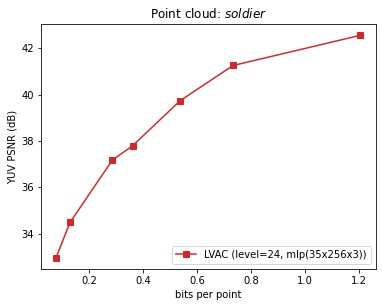

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4.5))
psnr = 20 * np.log10(255) - 10 * np.log10(dist)
if config.extractor_model == "pa":
  channels = [config.num_channels + 3, config.num_channels]
elif config.extractor_model == "mlp":
  channels = [config.num_channels + (3 if config.position_type != "none" else 0)]
  if config.extractor_model == "mlp":
    channels.append(config.hidden_dim)
channels.append(3)
channels = "x".join(str(x) for x in channels)

plt.plot(rate, psnr, "-sC3", label=f"LVAC (level={config.target_level}, {config.extractor_model}({channels}))")
plt.xlabel("bits per point")
plt.ylabel(f"{config.distortion_colorspace.upper()} PSNR (dB)")
plt.title(f"Point cloud: $\it{config.point_cloud_name}$")
plt.legend(loc="lower right")

#Writing out Plyfile

In [ ]:
import copy

# Get the decompressed color attributes for a model.
inference_config = copy.copy(config)
color_attributes = main(inference_config, training=False, return_attributes=True)
if inference_config.output_colorspace == "yuv":
  color_attributes = convert_yuv_to_rgb(color_attributes)

# Create a new filename for the reconstruction with _lambda value.
path, filename = os.path.split(inference_config.original_vpc)
basename, ext = os.path.splitext(filename)
new_name = os.path.join(path, f"{basename}_lambda"
  f"{inference_config.entropy_multiplier}_{inference_config.extractor_model}"
  f"{ext}")

# Read in the original ply file and replace the color attributes.
create_new_plyfile(inference_config.original_vpc, new_name, color_attributes)